In [1]:
%matplotlib inline

In [2]:
import pickle
import random
import sys
from collections import defaultdict
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import rankdata

sys.path.append('../../pygkernels')
from pygkernels.data import Datasets

from sbm_neighbour_score import sbm_neighbour_score, graph_neighbour_score

In [3]:
kernels_names = [
    'Katz', 'logKatz',
    'For', 'logFor',
    'Comm', 'logComm',
    'Heat', 'logHeat',
    'NHeat', 'logNHeat',
    'SCT', 'SCCT',
    'RSP', 'FE',
    'PPR', 'logPPR',
    'ModifPPR', 'logModifPPR',
    'HeatPR', 'logHeatPR',
    'DF', 'logDF',
    'Abs', 'logAbs',
    'SP-CT'
]

shuffle = lambda x: sorted(x, key=lambda k: random.random())

def dict_argmax(dct, score_key):
    best_key = list(dct.keys())[0]
    best_val = dct[best_key]
    for k, v in dct.items():
        if v[score_key] > best_val[score_key]:
            best_key, best_val = k, v
    return best_key, best_val

CACHE_ROOT = '../../cache/cache'

def calc_avranks(results):  # {dataset: {classifier: accuracy}}
    ranks = defaultdict(list)
    for dataset, classifier_accuracy in results.items():
        if type(dataset) == tuple:
            dataset = '_'.join([str(x) for x in dataset])
        classifiers, accuracies = zip(*list(classifier_accuracy.items()))
        for classifier, rank in zip(classifiers, rankdata(accuracies)):
            ranks[classifier].append(rank)
    ranks = {k: np.mean(v) for k, v in sorted(ranks.items(), key=lambda x: x[0])}
    return list(ranks.values()), list(ranks.keys()), len(results)


# SBM

In [4]:
columns = [
    (100, 2, 0.05, 0.001),
    (100, 2, 0.05, 0.002),
    (100, 2, 0.05, 0.005),
    (100, 2, 0.05, 0.007),
    (100, 2, 0.05, 0.01),
    (100, 2, 0.05, 0.02),
    (100, 2, 0.05, 0.03),
    (100, 2, 0.05, 0.05),
    
    (100, 2, 0.1, 0.001),
    (100, 2, 0.1, 0.002),
    (100, 2, 0.1, 0.01),
    (100, 2, 0.1, 0.02),
    (100, 2, 0.1, 0.03),
    (100, 2, 0.1, 0.05),
    (100, 2, 0.1, 0.07),
    (100, 2, 0.1, 0.1),
    
    (100, 2, 0.15, 0.01),
    (100, 2, 0.15, 0.03),
    (100, 2, 0.15, 0.05),
    (100, 2, 0.15, 0.07),
    
    (100, 2, 0.2, 0.05),
    (100, 2, 0.2, 0.1),
    (100, 2, 0.2, 0.15),
    
    (100, 2, 0.3, 0.05),
    (100, 2, 0.3, 0.1),
    (100, 2, 0.3, 0.15),
    
    (102, 3, 0.3, 0.05),
    (102, 3, 0.3, 0.1),
    (102, 3, 0.3, 0.15),
    
    (100, 4, 0.3, 0.1),
    (100, 4, 0.3, 0.15),
    
    (200, 2, 0.3, 0.05),
    (200, 2, 0.3, 0.1),
    (200, 2, 0.3, 0.15),
    
    (201, 3, 0.3, 0.1),
    
    (200, 4, 0.3, 0.1),
    (200, 4, 0.3, 0.15)
]

def column2str(column):
    n, k, p_in, p_out = column
    return f'{n}_{k}_{p_in:.2f}_{p_out:.3f}'

sbm_datasets = [column2str(x) for x in columns]

In [5]:
with open(f'{CACHE_ROOT}/sbm_inits_bestparam_byari_individual.pkl', 'rb') as f:
    sbm_results = pickle.load(f)  # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
with open(f'{CACHE_ROOT}/sbm_modularity.pkl', 'rb') as f:
    sbm_modularity = pickle.load(f)  # {(dataset, graph_idx): modularity}

In [6]:
sbm_results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in sbm_results.items():
    sbm_results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(sbm_datasets, kernels_names):  # {dataset, {kernel_name: mean_bestari}}
    sbm_results_m3_dka[dataset][kernel_name] = np.mean(sbm_results_m3_dka[dataset][kernel_name])

sbm_meanari = {k: np.mean(list(v.values())) for k, v in sbm_results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(sbm_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

100_2_0.05_0.050: 0.04
100_2_0.10_0.100: 0.05
100_2_0.05_0.030: 0.10
100_2_0.10_0.070: 0.10
100_2_0.20_0.150: 0.13
100_2_0.05_0.020: 0.16
100_2_0.10_0.050: 0.22
100_4_0.30_0.150: 0.22
200_4_0.30_0.150: 0.36
102_3_0.30_0.150: 0.38
100_2_0.15_0.070: 0.40
100_2_0.05_0.010: 0.45
100_4_0.30_0.100: 0.52
100_2_0.20_0.100: 0.53
100_2_0.05_0.007: 0.59
100_2_0.10_0.030: 0.59
100_2_0.05_0.005: 0.72
100_2_0.15_0.050: 0.74
100_2_0.30_0.150: 0.76
102_3_0.30_0.100: 0.78
200_4_0.30_0.100: 0.80
100_2_0.10_0.020: 0.82
200_2_0.30_0.150: 0.86
201_3_0.30_0.100: 0.88
100_2_0.05_0.002: 0.90
100_2_0.15_0.030: 0.93
100_2_0.30_0.100: 0.93
100_2_0.20_0.050: 0.93
102_3_0.30_0.050: 0.94
100_2_0.10_0.010: 0.94
100_2_0.05_0.001: 0.94
200_2_0.30_0.100: 0.95
100_2_0.10_0.002: 0.99
100_2_0.10_0.001: 0.99
100_2_0.15_0.010: 0.99
100_2_0.30_0.050: 1.00
200_2_0.30_0.050: 1.00


In [7]:
sbm_meanmodularity = dict()
for dataset in sbm_datasets:
    sbm_meanmodularity[dataset] = np.mean([sbm_modularity[(dataset, graph_idx)] for graph_idx in range(100)])
for dataset, modularity in sorted(list(sbm_meanmodularity.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

100_2_0.05_0.050: -0.01
100_2_0.10_0.100: -0.01
100_2_0.20_0.150: 0.07
100_2_0.10_0.070: 0.09
100_2_0.05_0.030: 0.12
100_4_0.30_0.150: 0.14
200_4_0.30_0.150: 0.14
102_3_0.30_0.150: 0.16
100_2_0.20_0.100: 0.16
100_2_0.30_0.150: 0.16
100_2_0.10_0.050: 0.16
200_2_0.30_0.150: 0.16
100_2_0.15_0.070: 0.17
100_2_0.05_0.020: 0.21
100_4_0.30_0.100: 0.24
200_4_0.30_0.100: 0.25
100_2_0.30_0.100: 0.25
100_2_0.15_0.050: 0.25
200_2_0.30_0.100: 0.25
102_3_0.30_0.100: 0.26
201_3_0.30_0.100: 0.26
100_2_0.10_0.030: 0.27
100_2_0.20_0.050: 0.29
100_2_0.15_0.030: 0.33
100_2_0.05_0.010: 0.33
100_2_0.10_0.020: 0.33
100_2_0.30_0.050: 0.35
200_2_0.30_0.050: 0.36
100_2_0.05_0.007: 0.37
100_2_0.05_0.005: 0.40
100_2_0.10_0.010: 0.41
102_3_0.30_0.050: 0.41
100_2_0.15_0.010: 0.44
100_2_0.05_0.002: 0.46
100_2_0.05_0.001: 0.48
100_2_0.10_0.002: 0.48
100_2_0.10_0.001: 0.49


In [8]:
def extract_feature_sbm(dataset_name, feature):
    n, k, p_in, p_out = [float(x) for x in dataset_name.split('_')]
    if feature == 'n':
        return n
    elif feature == 'k':
        return k
    elif feature == 'p_in':
        return p_in
    elif feature == 'p_out':
        return p_out
    elif feature == 'p_in/p_out':
        return p_in / p_out
    elif feature == 'n/k':
        return n / k
    elif feature == 'n/k * p_in/p_out':
        return (n / k) * (p_in / p_out)
    elif feature == 'log(n/k) * p_in/p_out':
        return np.log(n) / k * (p_in / p_out)
    elif feature == 'sbm_neighbour_score':
        return sbm_neighbour_score(int(n), int(k), p_in, p_out)

# Datasets

In [9]:
datasets_datasets = [
    'cora_DB', 'cora_EC', 'cora_HA', 'cora_HCI', 'cora_IR', 'cora_Net',
    'dolphins',
    'eu-core',
    'eurosis',
    'football',
    'karate',
    'news_2cl1_0.1', 'news_2cl2_0.1', 'news_2cl3_0.1',
    'news_3cl1_0.1', 'news_3cl2_0.1', 'news_3cl3_0.1',
    'news_5cl1_0.1', 'news_5cl2_0.1', 'news_5cl3_0.1',
    'polblogs',
    'polbooks',
    'sp_school_day_1', 'sp_school_day_2'
]
actual_graphs = Datasets()

In [10]:
with open(f'{CACHE_ROOT}/datasets_inits_bestparam_byari_individual_0.1.pkl', 'rb') as f:
    datasets_results = pickle.load(f)  # {(dataset, kernel_name, graph_idx): {scorename_initname: best_ari}}
with open(f'{CACHE_ROOT}/datasets_modularity_0.1.pkl', 'rb') as f:
    datasets_modularity = pickle.load(f)  # {(dataset, graph_idx): modularity}

In [11]:
datasets_results_m3_dka = defaultdict(lambda: defaultdict(list)) # {dataset, {kernel_name: [best_ari_for_graph]}}
for (dataset, kernel_name, graph_idx), si_ari in datasets_results.items():
    datasets_results_m3_dka[dataset][kernel_name].append(si_ari['modularity_any3'])
for dataset, kernel_name in product(datasets_datasets, kernels_names):  # {dataset, {kernel_name: best_ari}}
    datasets_results_m3_dka[dataset][kernel_name] = np.mean(datasets_results_m3_dka[dataset][kernel_name])

datasets_meanari = {k: np.mean(list(v.values())) for k, v in datasets_results_m3_dka.items()}  # {dataset, mean_mean_bestari}
for dataset, meanari in sorted(list(datasets_meanari.items()), key=lambda x: x[1]):
    print(f'{dataset}: {meanari:.2f}')

cora_Net: 0.18
cora_DB: 0.18
cora_EC: 0.27
cora_IR: 0.30
eu-core: 0.34
cora_HA: 0.38
news_5cl3_0.1: 0.42
news_5cl2_0.1: 0.49
cora_HCI: 0.51
news_5cl1_0.1: 0.61
news_3cl2_0.1: 0.62
news_3cl3_0.1: 0.66
news_2cl2_0.1: 0.67
polbooks: 0.69
sp_school_day_1: 0.72
news_3cl1_0.1: 0.73
news_2cl1_0.1: 0.73
polblogs: 0.73
sp_school_day_2: 0.74
eurosis: 0.74
news_2cl3_0.1: 0.83
football: 0.87
dolphins: 0.93
karate: 1.00


In [12]:
datasets_meanmodularity = datasets_modularity
for dataset, modularity in sorted(list(datasets_meanmodularity.items()), key=lambda x: x[1]):
    print(f'{dataset}: {modularity:.2f}')

cora_EC: 0.19
sp_school_day_1: 0.29
eu-core: 0.31
sp_school_day_2: 0.32
news_2cl2_0.1: 0.34
cora_Net: 0.35
karate: 0.37
dolphins: 0.37
news_2cl1_0.1: 0.38
cora_IR: 0.38
polblogs: 0.41
polbooks: 0.41
news_2cl3_0.1: 0.42
news_5cl3_0.1: 0.42
cora_DB: 0.43
news_3cl2_0.1: 0.46
news_5cl2_0.1: 0.50
news_3cl3_0.1: 0.51
news_3cl1_0.1: 0.53
cora_HCI: 0.53
football: 0.55
news_5cl1_0.1: 0.56
cora_HA: 0.61
eurosis: 0.70


In [13]:
def extract_feature_datasets(dataset_name, feature):
    (A, partition), info = actual_graphs[dataset_name]
    n, k, p_in, p_out = info['n'], info['k'], info['p_in'], info['p_out']
    if feature == 'n':
        return n
    elif feature == 'k':
        return k
    elif feature == 'p_in':
        return p_in
    elif feature == 'p_out':
        return p_out
    elif feature == 'p_in/p_out':
        return p_in / p_out
    elif feature == 'n/k':
        return n / k
    elif feature == 'n/k * p_in/p_out':
        return (n / k) * (p_in / p_out)
    elif feature == 'log(n/k) * p_in/p_out':
        return np.log(n) / k * (p_in / p_out)
    elif feature == 'sbm_neighbour_score':
        return sbm_neighbour_score(int(n), int(k), p_in, p_out)
    elif feature == 'graph_neighbour_score':
        return graph_neighbour_score(A, partition)
    elif feature == 'graph_neighbour_score_noweight':
        return graph_neighbour_score(A, partition, weighting=None)

# Now apply

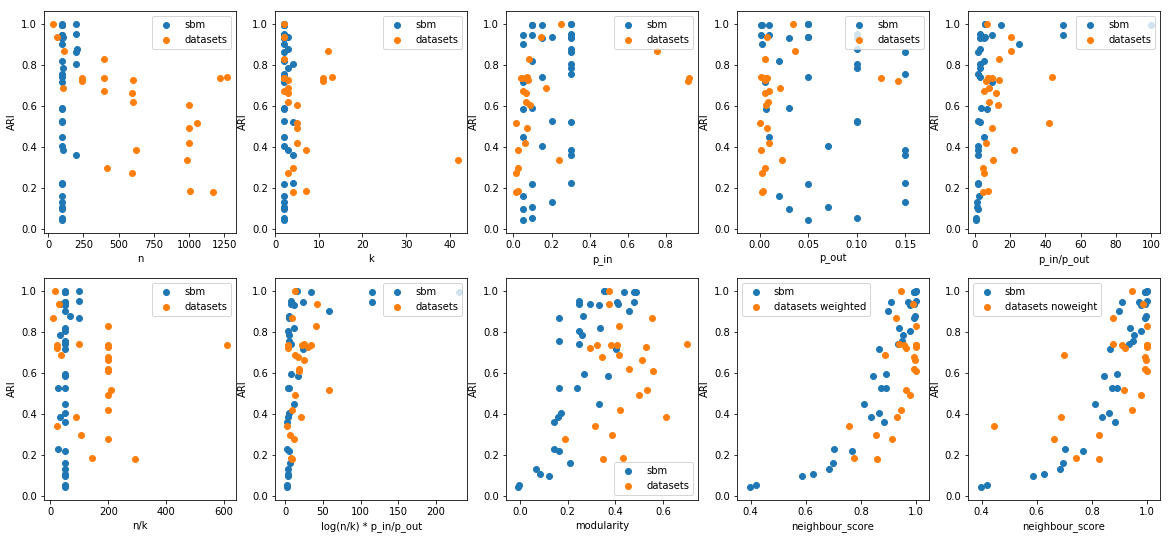

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(20, 9))
ax = np.ravel(ax)

for idx, feature in enumerate(['n', 'k', 'p_in', 'p_out', 'p_in/p_out', 'n/k', 'log(n/k) * p_in/p_out']):
    x, y = [], []
    for dataset in sbm_datasets:
        x.append(extract_feature_sbm(dataset, feature))
        y.append(sbm_meanari[dataset])
    ax[idx].scatter(x, y, label='sbm')

    x, y = [], []
    for dataset in datasets_datasets:
        x.append(extract_feature_datasets(dataset, feature))
        y.append(datasets_meanari[dataset])
    ax[idx].scatter(x, y, label='datasets')
        
    ax[idx].set_xlabel(feature)
    ax[idx].set_ylabel('ARI')
    ax[idx].legend(loc=1)
    
idx += 1
x, y = [], []
for dataset in sbm_datasets:
    x.append(sbm_meanmodularity[dataset])
    y.append(sbm_meanari[dataset])
ax[idx].scatter(x, y, label='sbm')

x, y = [], []
for dataset in datasets_datasets:
    x.append(datasets_meanmodularity[dataset])
    y.append(datasets_meanari[dataset])
ax[idx].scatter(x, y, label='datasets')

ax[idx].set_xlabel('modularity')
ax[idx].set_ylabel('ARI')
ax[idx].legend();


idx += 1
x, y = [], []
for dataset in sbm_datasets:
    x.append(extract_feature_sbm(dataset, 'sbm_neighbour_score'))
    y.append(sbm_meanari[dataset])
ax[idx].scatter(x, y, label='sbm')

x, y = [], []
for dataset in datasets_datasets:
    x.append(extract_feature_datasets(dataset, 'graph_neighbour_score'))
    y.append(datasets_meanari[dataset])
ax[idx].scatter(x, y, label='datasets weighted')

ax[idx].set_xlabel('neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].legend();


idx += 1
x, y = [], []
for dataset in sbm_datasets:
    x.append(extract_feature_sbm(dataset, 'sbm_neighbour_score'))
    y.append(sbm_meanari[dataset])
ax[idx].scatter(x, y, label='sbm')

x, y = [], []
for dataset in datasets_datasets:
    x.append(extract_feature_datasets(dataset, 'graph_neighbour_score_noweight'))
    y.append(datasets_meanari[dataset])
ax[idx].scatter(x, y, label='datasets noweight')

ax[idx].set_xlabel('neighbour_score')
ax[idx].set_ylabel('ARI')
ax[idx].legend();